In [1]:
import numpy as np
import tensorflow as tf
from utils_functions import *
from plan import *
import random
from main import *
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import datetime, os
from matplotlib import pyplot as plt
from tensorboard.plugins.hparams import api as hp



In [3]:
# controllo di star effettivamente usando la GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print("nome gpu: ",tf.test.gpu_device_name())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
nome gpu:  /device:GPU:0


## Preparazione dati

### Caricamento dataset statici

In [2]:
test=load_file("./Dataset/set_test")
train=load_file("./Dataset/set_training")
validation=load_file("./Dataset/set_validation")
 

File loaded
File loaded
File loaded


In [3]:
test=np.array(test,dtype=np.int8)
train=np.array(train,dtype=np.int8)
validation=np.array(validation,dtype=np.int8)

## Modello

In [4]:

logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)

]

#Cose da fare per migliorare la rete solo dopo aver fatto i primi tentativi con la rete proposta:
# * Provare ad aggiungere Regolarizzazione es. L1,L2 e dropout(solo nella fase di encoding)
# * Provare swish al posto di relu
# * Provare tf.keras.layers.BatchNormalization()(var_layer) 
# * Fare Hyperparameter Tuning  (ultima) www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

#PARAM:
#tf.keras.regularizers.L1(l1=1e-4)
param={"INPUT_SIZE" : 340,
"HIDDEN_SIZE" : 170,
"HIDDEN_SIZE2" : None,
"CODE_SIZE" : 34,
"KERNEL_INIZIALIZER":"he_uniform",
"KERNEL_REGULIZER":tf.keras.regularizers.L2(l2=1e-5),
'BIAS_REGULARIZER': None,
"ACTIVATION":'relu',
"OPTIMIZER":tf.keras.optimizers.Adam(learning_rate=0.001),
"EPOCHS":1000,
"BATCH_SIZE":10000,
"BATCH_NORMAIZATION":None
}


input_layer = Input(shape=(param["INPUT_SIZE"],))
x = Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] )(input_layer)

#x = Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"] )(x)
#x=tf.keras.layers.BatchNormalization()(x)
code = Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"])(x)
#x =Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"])(code)
x =Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"])(code)
#x=tf.keras.layers.BatchNormalization()(x)
output_layer = Dense(param["INPUT_SIZE"], activation='sigmoid')(x)

autoencoder = Model(input_layer, output_layer)
#variare learning_rate beta_1,beta_2, da fare per ultimo
#batch_size ???
autoencoder.compile(optimizer=param["OPTIMIZER"], loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
history=autoencoder.fit(x=train,y=train, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(validation,validation), callbacks=my_callbacks,
                      )

 #Gardare i risulati delle metriche su tensorbord                      

Epoch 1/1000
185/185 [==============================] - 4s 15ms/step - loss: 0.2020 - accuracy: 0.0911 - precision: 0.1986 - recall: 0.0782 - val_loss: 0.1322 - val_accuracy: 0.1263 - val_precision: 0.7339 - val_recall: 0.2513
Epoch 2/1000
185/185 [==============================] - 2s 12ms/step - loss: 0.1091 - accuracy: 0.1437 - precision: 0.7794 - recall: 0.4242 - val_loss: 0.0928 - val_accuracy: 0.1150 - val_precision: 0.8204 - val_recall: 0.5260
Epoch 3/1000
185/185 [==============================] - 2s 12ms/step - loss: 0.0852 - accuracy: 0.1283 - precision: 0.8421 - recall: 0.5724 - val_loss: 0.0789 - val_accuracy: 0.1415 - val_precision: 0.8622 - val_recall: 0.6038
Epoch 4/1000
185/185 [==============================] - 2s 12ms/step - loss: 0.0750 - accuracy: 0.1623 - precision: 0.8704 - recall: 0.6269 - val_loss: 0.0720 - val_accuracy: 0.1790 - val_precision: 0.8767 - val_recall: 0.6437
Epoch 5/1000
185/185 [==============================] - 2s 12ms/step - loss: 0.0683 - accura

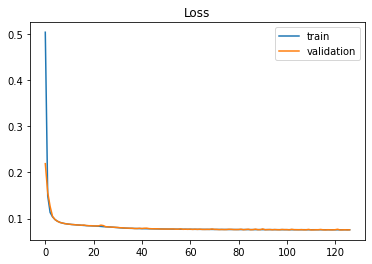

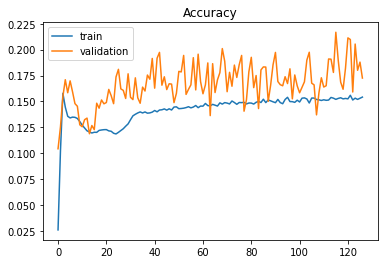

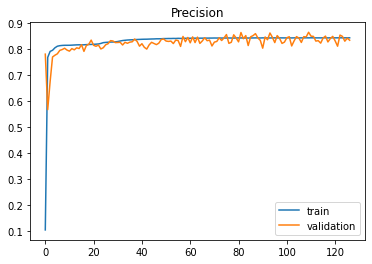

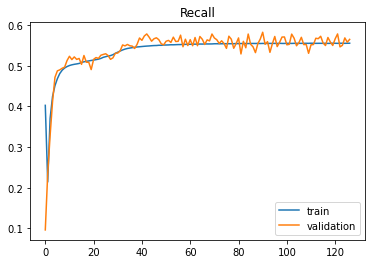

In [39]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss")
plt.show()
    
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.legend()
plt.title("Precision")
plt.show()

plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.legend()
plt.title("Recall")
plt.show()




In [5]:
#val_predictions = autoencoder.predict(validation)
test_predictions = autoencoder.predict(test)

7211/7211 [==============================] - 8s 1ms/step


In [15]:
print(test_predictions[100])

[1.2056666e-34 3.7509238e-08 1.0000000e+00 2.1906119e-09 0.0000000e+00
 0.0000000e+00 2.9932719e-37 0.0000000e+00 1.3173281e-20 1.6850327e-09
 3.6585901e-10 1.0000000e+00 5.8269778e-12 4.7875283e-13 1.3448592e-19
 2.6951265e-12 3.3827955e-26 1.3927692e-17 2.5884542e-12 1.7023633e-21
 1.8697716e-30 4.1444692e-32 5.4063289e-08 1.5994294e-14 1.0000000e+00
 4.8578028e-07 3.9291961e-15 1.2534687e-21 0.0000000e+00 1.4159281e-06
 5.6740154e-15 3.7309560e-06 2.2487038e-08 6.1930446e-27 3.2837680e-15
 2.3887608e-27 1.0000000e+00 9.9999917e-01 4.1002798e-25 2.6033808e-07
 1.8447404e-16 6.5548661e-10 2.8090818e-19 0.0000000e+00 0.0000000e+00
 3.6610867e-30 6.5629474e-10 0.0000000e+00 4.3167520e-07 9.1611360e-29
 4.1703748e-21 0.0000000e+00 3.5231842e-11 3.7983317e-27 1.1947932e-33
 2.3297545e-25 8.0339833e-20 2.8888519e-16 9.0002636e-23 0.0000000e+00
 1.4708931e-19 1.9365353e-22 7.1920978e-14 9.9999392e-01 0.0000000e+00
 7.3325102e-10 1.3983675e-35 4.5919779e-23 1.9576335e-25 1.8419909e-16
 0.000

In [6]:
arr=results_info(test,test_predictions,logdir) 

Numero di vettori decodificati correttamente: 24255 su 230728 totali 
Rapporto: 10.512% 
Media num di errori per array: 4.089



AttributeError: 'Figure' object has no attribute 'hist'

<Figure size 432x288 with 0 Axes>

In [17]:
#Se i risultati sono buoni salva il modello in modo che possa essere riusato

dir_model= os.path.join(logdir,"myModel")
autoencoder.save(dir_model)

autoencoder.summary()

INFO:tensorflow:Assets written to: ./TestLogs/20220625-123155\myModel\assets


In [ ]:
PATH_TO_LOAD=""
loaded_model = tf.keras.models.load_model(PATH_TO_LOAD)

In [10]:
#%tensorboard --logdir logsTf
%load_ext tensorboard
#Avvio da terminale: spostarsi nella cartella dove è presente la cartella di log, > tensorboard --logdir nomecartella